# ECTA Cleaning

This notebook walks through how the ECTA articles were sorted into categories of articles and non-articles.

## Load Libraries

In [1]:
from tokenize import Ignore
from numpy import NaN
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
import time
from os import path
import os
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import matplotlib.pyplot as plt    

## Load Files
Replace these file paths with local file paths

In [2]:
masters = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\Master lists\\ECONOMETRICA_master.xlsx")
pivots = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\pivots\\ECONOMETRICA_pivots.xlsx")
scopus = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\Scopus\\ECONOMETRICA_SCOPUS.xlsx")
#datadump = pd.read_excel("C:\\Users\\sjwu1\\Journal_Data\\datadumps\\ECONOMETRICA_datadump.xlsx")

pd.set_option('display.max_colwidth', None)

## Create File names

In [343]:
authors="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\ECTA_authors.xlsx"
non_auth="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\ECTA_Nauthors.xlsx"
saveas="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\ECTA_processed.xlsx"
reviews="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\ECTA_reviews.xlsx"
misc="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\ECTA_misc.xlsx"
conf="C:\\Users\\sjwu1\\Journal_Data\\datadumps\\ECTA_conf.xlsx"

## Some random checks on the masters list

My assumption is that all data without author names must be miscellaneous documents like reports by the committee, forewords, front matters etc.. The goal of this notebook is to check for certain that all the documents without author names are actually miscellaneous documents and then classify them as miscellaneous (MISC). Hence, first we group everything the data by title to see the repetitive general content that can likely be removed.

In [344]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp[temp>1])

,title
back matter,439
front matter,430
news notes,193
announcements,146
accepted manuscripts,116
volume information,80
submission of manuscripts to econometrica,49
forthcoming papers,36
report of the secretary,31
report of the treasurer,31


Some repetitions are due to multiple comments. Now consider this list in absence of author names.

In [345]:
temp1=masters[masters['authors'].isna()]['title'].str.lower().value_counts()
pd.DataFrame(temp1)

,title
back matter,439
front matter,430
news notes,193
announcements,134
accepted manuscripts,116
volume information,80
submission of manuscripts to econometrica,49
forthcoming papers,36
news note,25
fellows of the econometric society,25


In [346]:
# block for testing regex matching
#pd.DataFrame(masters[masters['content_type'].isna()]['title'].str.lower().value_counts())
#masters[masters['title'].str.lower().str.match(r'(^|: )report of the')]
#masters[masters['title'].str.lower().str.match(r'(^|.*: )report of the')]
#masters.loc[masters['title'].str.lower().str.match(r'^combined references(.*)')==True,'content_type']='MISC'
#masters[masters['title'].str.lower().str.match(r'.*(members|members and subscribers)$')]

,Unnamed: 0,stable_url,authors,title,abstract,content_type,issue_url,pages
80,80,https://www.jstor.org/stable/45172310,Enrique Sentana,THE ECONOMETRIC SOCIETY ANNUAL REPORTS: REPORT OF THE SECRETARY,NaN,NaN,https://www.jstor.org/stable/10.2307/i40222381,349-357
81,81,https://www.jstor.org/stable/45172311,Enrique Sentana,THE ECONOMETRIC SOCIETY ANNUAL REPORTS: REPORT OF THE TREASURER,NaN,NaN,https://www.jstor.org/stable/10.2307/i40222381,359-364
82,82,https://www.jstor.org/stable/45172312,"Joel Sobel, Dirk Bergemann, Itzhak Gilboa, Ulrich K. Müller, Aviv Nevo, Giovanni L. Violante and Fabrizio Zilibotti",THE ECONOMETRIC SOCIETY ANNUAL REPORTS: REPORT OF THE EDITORS 2017–2018,NaN,NaN,https://www.jstor.org/stable/10.2307/i40222381,365-367
84,84,https://www.jstor.org/stable/45172314,Donald Andrews and Jeffrey Ely,THE ECONOMETRIC SOCIETY ANNUAL REPORTS: REPORT OF THE EDITORS OF THE MONOGRAPH SERIES,NaN,NaN,https://www.jstor.org/stable/10.2307/i40222381,381-383
943,943,https://www.jstor.org/stable/40056534,Rafael Repullo,The Econometric Society Reports: Report of the Secretary,NaN,NaN,https://www.jstor.org/stable/10.2307/i40002377,327-333
944,944,https://www.jstor.org/stable/40056535,Rafael Repullo,The Econometric Society Reports: Report of the Treasurer,NaN,NaN,https://www.jstor.org/stable/10.2307/i40002377,335-340
945,945,https://www.jstor.org/stable/40056536,"Stephen Morris, Daron Acemoglu, Steve Berry, David Levine, Whitney Newey, Larry Samuelson and Harald Uhlig",The Econometric Society Annual Reports: Report of the Editors 2007-2008,NaN,NaN,https://www.jstor.org/stable/10.2307/i40002377,341-345
947,947,https://www.jstor.org/stable/40056538,Andrew Chesher and George Mailath,The Econometric Society Annual Reports: Report of the Editors of the Monograph Series,NaN,NaN,https://www.jstor.org/stable/10.2307/i40002377,357-359
976,976,https://www.jstor.org/stable/40056501,Lars Peter Hansen,"The Econometric Society Annual Reports, 2007: Report of the President",NaN,NaN,https://www.jstor.org/stable/10.2307/i40002375,1225-1226
1089,1089,https://www.jstor.org/stable/4123117,"Rafael Repullo, Eddie Dekel, David Levine, Costas Meghir, Whitney Newey and Larry Samuelson",The Econometric Society Annual Reports: Report of the Secretary,NaN,NaN,https://www.jstor.org/stable/10.2307/i383441,291-297+299-308


Judging from the above anything with greater than or equal to 5 duplicates are miscellaneous. The next code blocks classify it as such.

In [ ]:
temp2=masters[masters['content_type'].isna()==True]['title'].str.lower().value_counts()
#pd.DataFrame(temp2)
removal=list(temp2[temp2>=5].index)
removal
masters.loc[masters.title.str.lower().isin(removal),'content_type']='MISC'

## Classifying miscellaneous content

In [350]:
scopus.rename(columns = {'abstract':'abstract2', 'title':'title2', 'authors':'authors2'}, inplace = True)
scopus['pages2']=scopus['pages']
masters['pages']=masters['pages'].str.strip()  
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = NaN  
masters[masters['title'].str.lower().str.contains('\[illustration\]')==True]

,Unnamed: 0,stable_url,authors,title,abstract,content_type,issue_url,pages
1,1,https://www.jstor.org/stable/45238022,NaN,[Illustration],NaN,NaN,https://www.jstor.org/stable/10.2307/i40226149,NaN
551,551,https://www.jstor.org/stable/23524986,NaN,[Illustration],NaN,NaN,https://www.jstor.org/stable/10.2307/i23524124,NaN
717,717,https://www.jstor.org/stable/41237778,NaN,[Illustration],NaN,NaN,https://www.jstor.org/stable/10.2307/i40055874,NaN


In [351]:
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'front matter').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'back matter').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'news note(|s)').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'announcements').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'accepted manuscripts').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'volume information').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'submission of manuscripts to econometrica').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'forthcoming papers').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters['title'].str.lower().str.match(r'(^|.*: )report of the'), 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'.*report (of|on) the(.*)(editors|fellows)'), 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'meeting of the econometric society'), 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'(^|.*: )report of the.*')==True,'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('econometric society')==True,'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('econometrica')==True,'content_type']='MISC'
masters.loc[(masters['title'].str.lower().str.contains('report')==True) & (masters['authors'].isna()==True),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.strip().str.match(r'treasurer(.*)report'),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.strip().str.contains(r'report from the president'),'content_type']='MISC'
masters.loc[((masters['title'].str.lower().str.contains('announcement of the')==True)),'content_type']='MISC'
masters.loc[((masters['title'].str.lower().str.match(r'editor(.*)note')==True)),'content_type']='MISC'
masters.loc[((masters['title'].str.lower().str.match(r'(.*):program$')==True)),'content_type']='MISC'
masters.loc[((masters['title'].str.lower().str.strip().str.match(r'accountant(.*)opinion')==True)),'content_type']='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'unpublished research memoranda').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[((masters['title'].str.lower().str.strip().str.match(r'^(obituary|death(s?) of members)$')==True)),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'.*fellows$'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('nomination of fellows'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'.*editorial$'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'(index of authors|summary of accounts)'),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'.*(members|members and subscribers)$'),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('\[illustration\]'),'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('abstracts of papers'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('frisch medal award'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^membership list'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('additive preferences'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('communications'),'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains('letters to the editor'),'content_type']="MISC"


## Classifying other content

In [352]:
sum(masters.content_type.isna())
#masters.shape[0]

6569

In [353]:
masters.loc[masters['authors'].str.lower().str.match(r'^review(ed|) by(.*)')==True,'content_type']='Review' #reviews
masters.loc[(masters['title'].str.lower().str.match(r'(.*) by (.*)')==True) & (masters.authors.isna()==True),'content_type']='Review2' 
#possible reviews that don't have author names
masters[(masters['content_type']=='Review2') | (masters['content_type']=='Review')].shape[0] #reviews

935

In [354]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )comment(|.*)$')==True,'content_type']='Comment'
masters[masters['content_type']=='Comment'].shape[0] #comments

70

In [355]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )reply(| to.*)$')==True,'content_type']="Reply"
masters[masters['content_type']=='Reply'].shape[0]

43

In [356]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True,'content_type']="Rejoinder"
masters[masters['content_type']=='Rejoinder'].shape[0]

14

In [357]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(^|a )discussion(|.*)$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*:.*(|a )discussion(|s)$')==True,'content_type']='Discussion'
masters[masters['content_type']=='Discussion'].shape[0]

9

In [358]:
masters.loc[masters['content_type'].isna(),'content_type']="Article"
masters[masters['content_type']=='Article'].shape[0]

5501

In [1]:
#masters[masters['title'].str.lower().str.match(r'^\washington notes$')==True]
masters[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True]

masters[masters.content_type=='Discussion'].shape[0]

NameError: name 'masters' is not defined

## Summary Statistics

The values below show the full dataset. The masterlist is merged with pivot files to be able to sort by date.

In [360]:
pd.DataFrame(masters['content_type'].value_counts())

,content_type
Article,5501
MISC,2658
Review,930
Comment,70
Reply,43
Rejoinder,14
Discussion,9
Review2,5


## Consider the pivots file
At times, conference papers are structured differently to normal articles. Hence, it may be necessary to distinguish conference papers from common articles.

In [361]:
pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'(.*)(supplement|proceedings|annual meeting|survey)(.*)'),'type']="S"
pivots.loc[pivots.type.isna(),'type']='N'
pivots.type.value_counts()

N    443
S      6
Name: type, dtype: int64

Merge and calculate value counts of all the content types.

In [362]:
result = pd.merge(masters, pivots[['issue_url','year','volume','issue','journal','type']], how="left", on=["issue_url", "issue_url"])

In [363]:
pd.DataFrame(result.content_type.value_counts())

,content_type
Article,5501
MISC,2658
Review,930
Comment,70
Reply,43
Rejoinder,14
Discussion,9
Review2,5


In [364]:
pd.DataFrame(result[result.year>1939].content_type.value_counts())

,content_type
Article,5290
MISC,2517
Review,930
Comment,70
Reply,41
Rejoinder,10
Discussion,9
Review2,5


In [365]:
pd.DataFrame(result[(result.year>1939) & (result.year<2011)].content_type.value_counts())

,content_type
Article,4736
MISC,2302
Review,930
Comment,67
Reply,39
Rejoinder,10
Discussion,9
Review2,5


In [366]:
result.to_excel(saveas, index=False)

In [5]:
cleaned=pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\processed\\ECTA_processed.xlsx')
cleaned['volume']=cleaned['volume'].astype(int)

scopus['volume']=scopus['volume'].astype(int)
scopus['year']=scopus['year'].astype(int)
cleaned['year']=cleaned['year'].astype(int)

cleaned['issue']=cleaned['issue'].astype(str)
scopus['pages']=scopus['pages'].str.strip()
cleaned['pages']=cleaned['pages'].astype(str)


scopus['issue'] = scopus['issue'].fillna(0)
#scopus[col] = scopus[col].astype(float)
scopus['issue'] = scopus['issue'].astype(int)
scopus['issue'] = scopus['issue'].astype(str)
scopus['issue'] = scopus['issue'].replace('0', np.nan)


In [32]:
#Note that we only have data up to 2016 in the masterlists because of the moving wall on JSTOR
print(sum(scopus['year']<=2019))
print(scopus.shape)

1549
(1717, 14)


In [73]:
x=cleaned[['year','issue','volume','pages']].value_counts().reset_index()
checks=pd.merge(cleaned, x, on=['year', 'issue','volume','pages'], how='left')
y=pd.merge(checks[(pd.isna(checks[0])==False) & (checks[0]<2)], scopus, on=['year', 'issue','volume','pages'], how='left')
temp=checks[checks[0]>=2].rename(columns={'authors':'authors_x','title':'title_x','abstract':'abstract_x','journal':'journal_x'})
Merged=pd.concat([y,temp]).reset_index(drop=True)

In [74]:
sum(Merged['title_y'].isna()==False)
Merged

stable_url  \
0     https://www.jstor.org/stable/45238023   
1     https://www.jstor.org/stable/45238024   
2     https://www.jstor.org/stable/45238025   
3     https://www.jstor.org/stable/45238026   
4     https://www.jstor.org/stable/45238027   
...                                     ...   
9225   https://www.jstor.org/stable/1912222   
9226   https://www.jstor.org/stable/1912223   
9227   https://www.jstor.org/stable/1912225   
9228   https://www.jstor.org/stable/1912226   
9229   https://www.jstor.org/stable/1912242   

                                           authors_x  \
0          Martin Beraja, Erik Hurst and Juan Ospina   
1                                 Amanda Friedenberg   
2                  Gabriel Carroll and Georgy Egorov   
3            Luciano de Castro and Antonio F. Galvao   
4     Mira Frick, Ryota Iijima and Tomasz Strzalecki   
...                                              ...   
9225                                             NaN   
9226                                             NaN   
9227                               Joseph Schumpeter   
9228                                             NaN   
9229                                             NaN   

                                                                        title_x  \
0                        THE AGGREGATE IMPLICATIONS OF REGIONAL BUSINESS CYCLES   
1     BARGAINING UNDER STRATEGIC UNCERTAINTY: THE ROLE OF SECOND-ORDER OPTIMISM   
2                             STRATEGIC COMMUNICATION WITH MINIMAL VERIFICATION   
3                                  DYNAMIC QUANTILE MODELS OF RATIONAL BEHAVIOR   
4                                                        DYNAMIC RANDOM UTILITY   
...                                                                         ...   
9225                                                         Volume Information   
9226                                                               Front Matter   
9227                                           The Common Sense of Econometrics   
9228                          [Photograph]: Antoine Augustin Cournot, 1801-1877   
9229                                                                Back Matter   

      abstract_x content_type                                       issue_url  \
0            NaN      Article  https://www.jstor.org/stable/10.2307/i40226149   
1            NaN      Article  https://www.jstor.org/stable/10.2307/i40226149   
2            NaN      Article  https://www.jstor.org/stable/10.2307/i40226149   
3            NaN      Article  https://www.jstor.org/stable/10.2307/i40226149   
4            NaN      Article  https://www.jstor.org/stable/10.2307/i40226149   
...          ...          ...                                             ...   
9225         NaN         MISC    https://www.jstor.org/stable/10.2307/i332704   
9226         NaN         MISC    https://www.jstor.org/stable/10.2307/i332704   
9227         NaN      Article    https://www.jstor.org/stable/10.2307/i332704   
9228         NaN      Article    https://www.jstor.org/stable/10.2307/i332704   
9229         NaN         MISC    https://www.jstor.org/stable/10.2307/i332704   

          pages  year  volume issue  ...  \
0     1789-1833  2019      87     6  ...   
1     1835-1865  2019      87     6  ...   
2     1867-1892  2019      87     6  ...   
3     1893-1939  2019      87     6  ...   
4     1941-2002  2019      87     6  ...   
...         ...   ...     ...   ...  ...   
9225        nan  1933       1     1  ...   
9226        nan  1933       1     1  ...   
9227       5-12  1933       1     1  ...   
9228       5-12  1933       1     1  ...   
9229        nan  1933       1     1  ...   

                                                  authors_y  \
0         Beraja, M.--a--\nHurst, E.--b--\nOspina, J.--c--    
1                                           Friedenberg, A.   
2                  Carroll, G.--a--\nEgorov, G.--b-- --c--    
3              de Castro, L.--a-- --b--\nGal

In [75]:
count=0
for m in Merged.index:
    if(pd.isna(Merged.iloc[m]['title_y'])==False):
        ratio=SequenceMatcher(None, Merged.iloc[m]['title_x'].lower(), Merged.iloc[m]['title_y'].lower()).ratio()
        if((ratio<0.7) & (Merged.iloc[m]['content_type']!='MISC')):
            print(Merged.iloc[m]['year'])
            print(ratio)
            count+=1
            if (pd.isna(Merged.iloc[m]['authors_x'])==False) & (pd.isna(Merged.iloc[m]['authors_y'])==False):
                A_ratio=SequenceMatcher(None, Merged.iloc[m]['authors_x'].lower(), Merged.iloc[m]['authors_y'].lower()).ratio()
                print(A_ratio)
            else:
                print('Author issue')
                print(Merged.iloc[m]['authors_x'])
                print(Merged.iloc[m]['authors_y'])
            print(Merged.iloc[m]['stable_url'])
            print('vol: '+str(Merged.iloc[m]['volume']))
            print('issue: '+str(Merged.iloc[m]['issue']))
            print('pages: '+Merged.iloc[m]['pages'])
            print('jstor: '+Merged.iloc[m]['title_x'])
            print('scopus: '+Merged.iloc[m]['title_y'])
            print('jstor: '+str(Merged.iloc[m]['authors_x']))
            print('scopus: '+str(Merged.iloc[m]['authors_y']))
            print('scopus index: '+str(scopus[scopus['title']==Merged.iloc[m]['title_y']].index))
            print(m)
            print()
print(count)

2010
0.6742857142857143
Author issue
nan
Mikusheva, A.
https://www.jstor.org/stable/40928972
vol: 78
issue: 5
pages: 1773
jstor: CORRIGENDUM TO "UNIFORM INFERENCE IN AUTOREGRESSIVE MODELS" (Econométrica, Vol. 75, No. 5, September 2007,1411-1452)
scopus: Corrigendum to "Uniform inference in autoregressive models"
jstor: nan
scopus: Mikusheva, A.
scopus index: Int64Index([907], dtype='int64')
683

2008
0.6029411764705882
0.46956521739130436
https://www.jstor.org/stable/40056461
vol: 76
issue: 3
pages: 661-662
jstor: Corrigendum to "Estimating Long Memory in Volatility"
scopus: Erratum: Estimating long memory in volatility (Economietrica (2005) 73 (1283-1328))
jstor: Clifford M. Hurvich, Eric Moulines and Philippe Soulier
scopus: Hurvich, C.M.--a--
Moulines, E.--b--
Soulier, P.--b-- --c-- 
scopus index: Int64Index([704], dtype='int64')
848

2


In [76]:
sum(Merged['title_y'].isna()==False)

1517

In [77]:
Merged.rename(columns = {'authors_x':'Jstor_authors', 'title_x':'Jstor_title', 'abstract_x':'Jstor_abstract', 'journal_x':'Jstor_journal', 'authors_y':'scopus_authors','title_y':'scopus_title', 'abstract_y':'scopus_abstract', 'journal_y':'scopus_journal' }, inplace = True)

In [78]:
Merged.to_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\ECTA_M_sco_du.xlsx', index=False)

In [3]:
Merged=pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\ECTA_M_sco_du.xlsx')

In [4]:
inv=Merged[(Merged['year']<=1963) & (Merged['year']>=1940)&(Merged['content_type']!='MISC')&(Merged['content_type']!='Review')&(Merged['content_type']!='Discussion')]
inv.shape

(945, 23)

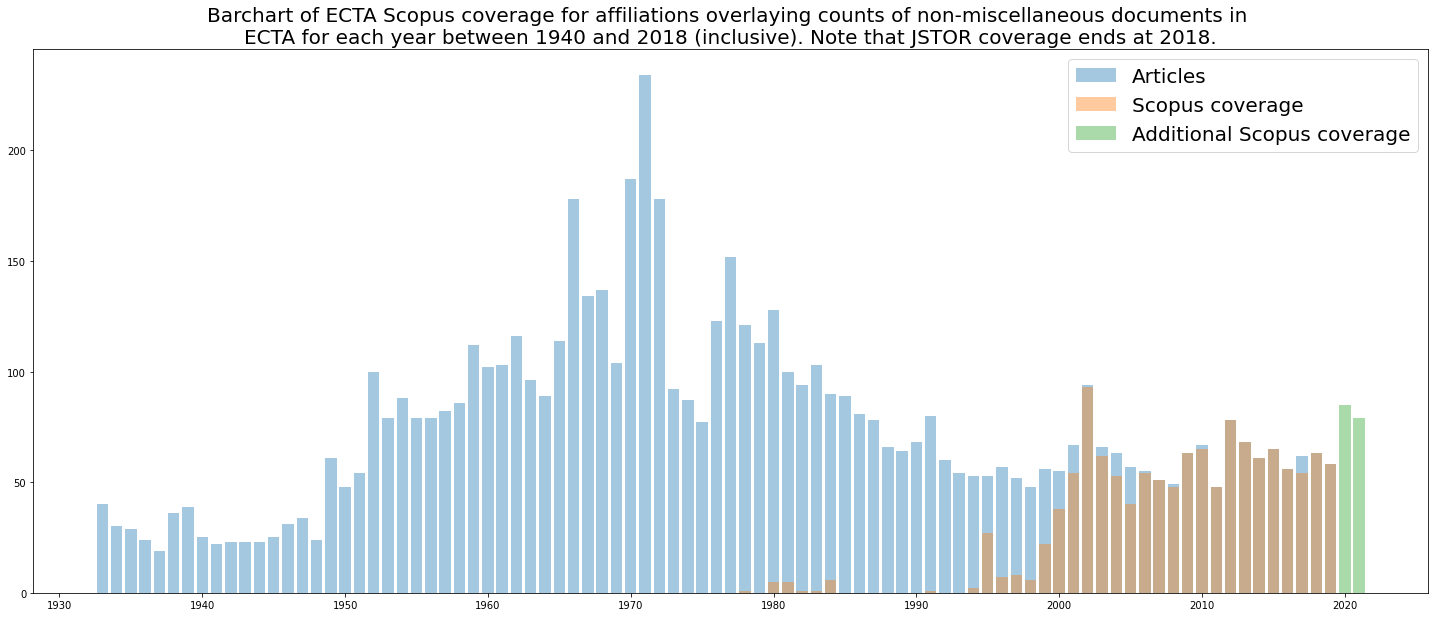

In [6]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
dta3=scopus[(scopus['affiliations'].isnull()==False) & (scopus['year']>2019)]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.bar(dta3.index, dta3, label='Additional Scopus coverage', alpha=0.4)
plt.title('Barchart of ECTA Scopus coverage for affiliations overlaying counts of non-miscellaneous documents in \nECTA for each year between 1940 and 2018 (inclusive). Note that JSTOR coverage ends at 2018.', fontsize=20)
plt.xticks(np.arange(1930, 2030, 10))
plt.legend(prop={'size': 20})

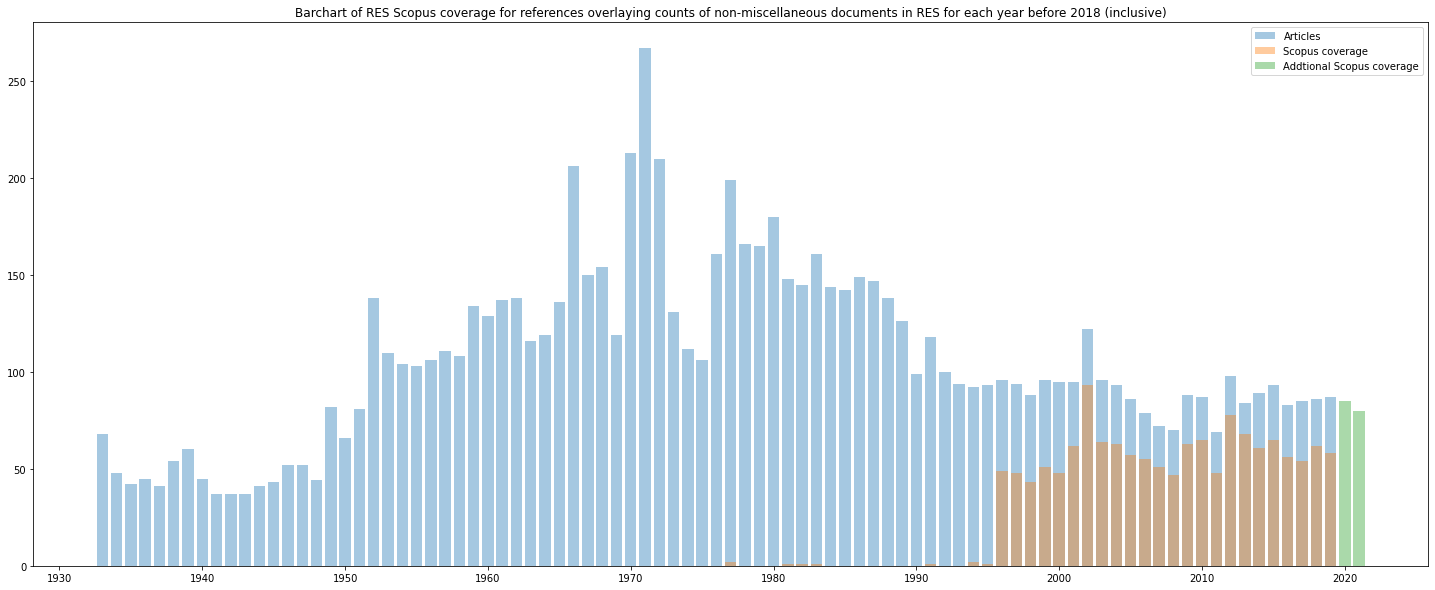

In [7]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged['year'].value_counts()
dta.index
plt.bar(dta.index, dta, alpha=0.4, label='Articles')

dta4=Merged[(Merged['citations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta4.index, dta4, alpha=0.4, label='Scopus coverage')
dta5=scopus[(scopus['citations'].isnull()==False) & (scopus['year']>2019)]['year'].value_counts()
plt.bar(dta5.index, dta5, alpha=0.4, label='Addtional Scopus coverage')
plt.title('Barchart of RES Scopus coverage for references overlaying counts of non-miscellaneous documents in RES for each year before 2018 (inclusive)')
plt.xticks(np.arange(1930, 2030, 10))
plt.legend()